In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import UMAP_neural_network

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

print(len(X_train), len(X_valid))

50000 10000


### define networks

In [7]:
dims = (28,28,1)
n_components = 2

In [8]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [9]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

### Create model and train

In [10]:
embedder = UMAP_neural_network(
    decoding_method="autoencoder", 
    training_epochs=5,
    max_sample_repeats_per_epoch=10,
    valid_X = X_valid,
    valid_Y = Y_valid,
    encoder=encoder,
    decoder=decoder,
    verbose=True,
    dims = dims,
    n_components = n_components
)

In [11]:
z = embedder.fit_transform(X_train)

Construct fuzzy simplicial set
Sun May 31 18:49:53 2020 Finding Nearest Neighbors
Sun May 31 18:49:53 2020 Building RP forest with 16 trees
Sun May 31 18:49:55 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 18:50:08 2020 Finished Nearest Neighbor Search
Sun May 31 18:50:10 2020 Embedding with TensorFlow


Sun May 31 18:58:24 2020 Finished embedding


### look at network architecture

In [12]:
embedder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 2,697,986
Trainable params: 2,697,986
Non-trainable params: 0
______________________________________________

In [13]:
embedder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 12544)             6435072   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)        

### Plot model output

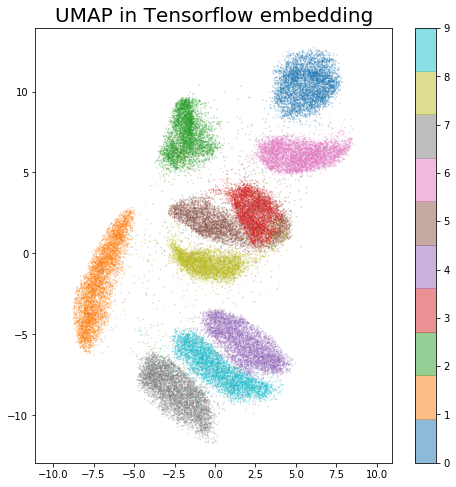

In [14]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### embed test data

In [15]:
z_test = embedder.transform(X_test)

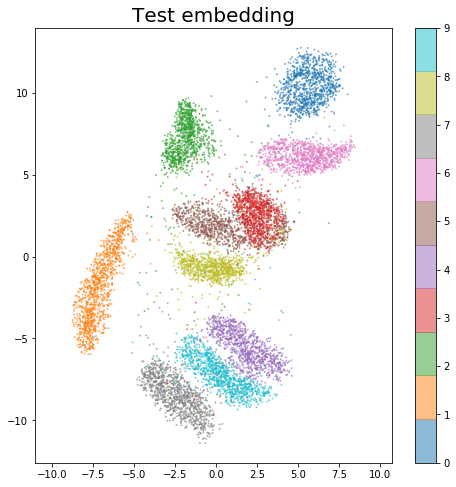

In [16]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_test[:, 0],
    z_test[:, 1],
    c=Y_test.astype(int)[:len(z)],
    cmap="tab10",
    s=1.0,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Test embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [17]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [18]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.590976e+09,1,5.315345,train,umap_loss
1,1.590976e+09,2,3.612308,train,umap_loss
2,1.590976e+09,3,2.690392,train,umap_loss


In [19]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

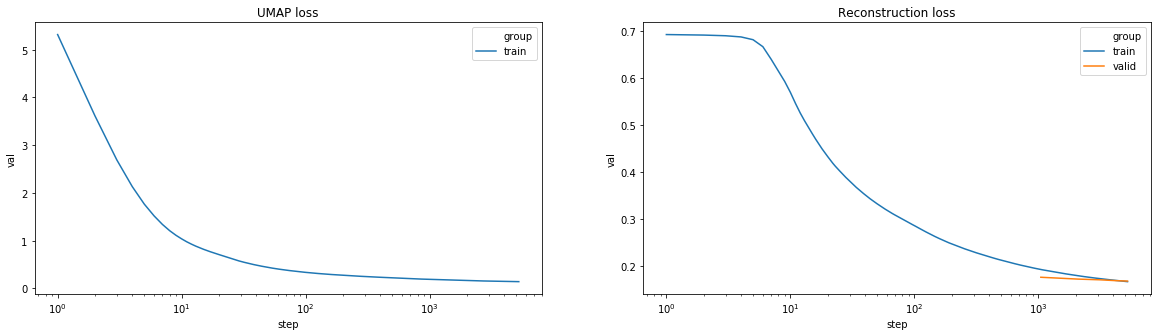

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Reconstruction loss')

### Compare to direct embedding with base UMAP

In [21]:
from umap import UMAP

In [22]:
z_umap = UMAP(verbose=True).fit_transform(X_train)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun May 31 18:58:31 2020 Finding Nearest Neighbors
Sun May 31 18:58:31 2020 Building RP forest with 16 trees
Sun May 31 18:58:32 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Sun May 31 18:58:38 2020 Finished Nearest Neighbor Search
Sun May 31 18:58:38 2020 Construct embedding
	completed  0  /  200 epochs
	complet

In [23]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.19266663352989308


Text(0.5, 1.0, 'UMAP with UMAP-learn')

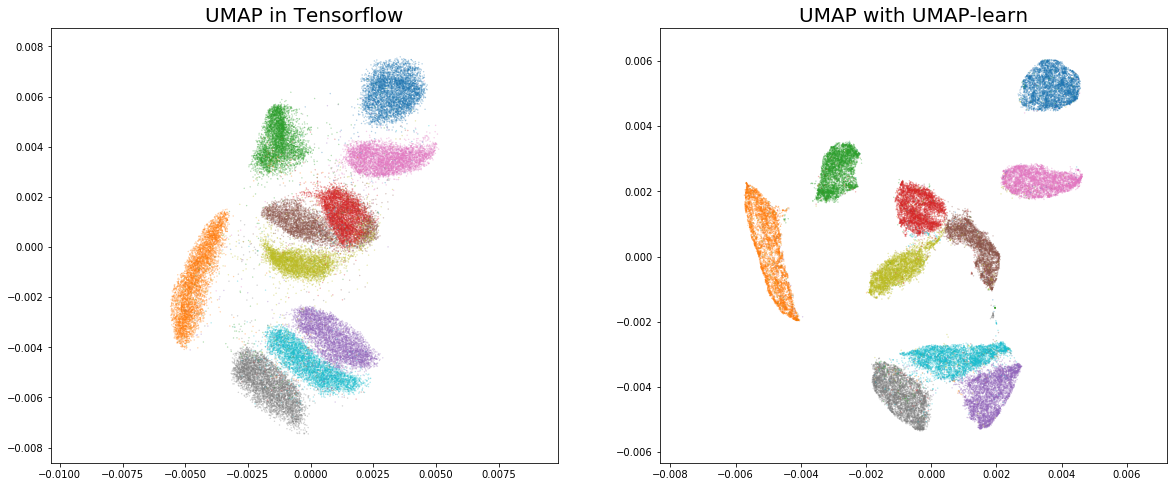

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);

### View reconstructions on test data

In [25]:
X_test_recon = embedder.inverse_transform(z_test)

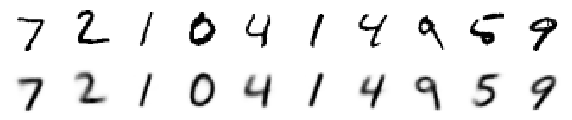

In [26]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex,2))
for i in range(nex):
    axs[0,i].matshow(X_test[i].reshape(28,28), cmap='Greys')
    axs[1,i].matshow(X_test_recon[i].reshape(28,28), cmap="Greys")
for ax in axs.flatten():
    ax.axis('off')

### Show reconstructions over grid

In [27]:
embedding_x = z[:,0]
embedding_y = z[:,1]

In [113]:
def uniform_sample_projection_2d(embedding_x, embedding_y, max_tiles = 20, pct_coverage = 99.99 ):
    xmin = np.percentile(embedding_x, (100-pct_coverage))
    xmax = np.percentile(embedding_x, (pct_coverage))
    ymin = np.percentile(embedding_y, (100-pct_coverage))
    ymax = np.percentile(embedding_y, (pct_coverage))

    tile_spacing = np.max([xmax - xmin, ymax - ymin])/max_tiles
    # add a little slack to tile around distribution
    x_excess = tile_spacing * ((xmax - xmin) % tile_spacing) * 1.01 / 2
    y_excess = tile_spacing * ((ymax - ymin) % tile_spacing) * 1.01 / 2

    x_tiles = np.arange(xmin - x_excess, xmax + x_excess, tile_spacing)
    y_tiles = np.arange(ymin - y_excess, ymax + y_excess, tile_spacing)[::-1]
    x_tiled = np.repeat(x_tiles, len(y_tiles))
    y_tiled = np.tile(y_tiles, len(x_tiles))
    z_tiled = np.vstack([x_tiled, y_tiled]).T
    return z_tiled, len(x_tiles), len(y_tiles), x_tiled, y_tiled

def tiled_sample_from_uniform_sample(tiled_reconstructions, x_tiles, y_tiles, dims = (28,28,1)):
    tiled_reconstructions = tiled_reconstructions.reshape(([len(tiled_reconstructions)] + list(dims)))
    tiled_reconstructions_rec = tiled_reconstructions.reshape(
        [x_tiles, y_tiles] + list(tiled_reconstructions.shape[1:])
    ).squeeze()

    recon_tiled = (
        tiled_reconstructions_rec.swapaxes(0, 1)
        .swapaxes(2, 1)
        .reshape(
            [
                tiled_reconstructions_rec.shape[1] * dims[0],
                tiled_reconstructions_rec.shape[0] * dims[1],
                dims[2]
            ]
        )
    )
    return recon_tiled

In [114]:
z_tiled, x_tiles, y_tiles, x_tiled, y_tiled = uniform_sample_projection_2d(embedding_x, embedding_y)
tiled_reconstructions = embedder.inverse_transform(z_tiled)
tiled_reconstructions = tiled_sample_from_uniform_sample(tiled_reconstructions, x_tiles, y_tiles)

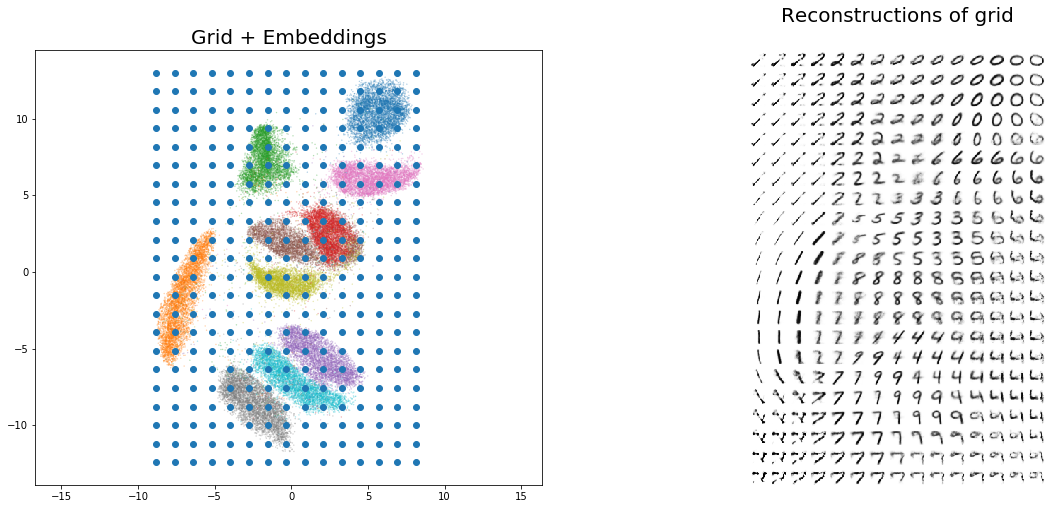

In [115]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    embedding_x,
    embedding_y,
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.set_title("Grid + Embeddings", fontsize=20)
#plt.colorbar(sc, ax=ax)
ax.axis('equal')
ax.scatter(x_tiled, y_tiled)
ax = axs[1]
ax.set_title("Reconstructions of grid", fontsize=20)

ax.matshow(tiled_reconstructions.squeeze(), cmap = plt.cm.Greys)
ax.axis('off')
plt.show()

### Compute magnitude of gradient from Z -> X

In [122]:
def compute_magnitude_gradient(embedding_x, embedding_y, res = 500):
    z_tiled, x_tiles, y_tiles, x_tiled, y_tiled = uniform_sample_projection_2d(embedding_x, embedding_y, res)
    tiled_reconstructions = embedder.inverse_transform(z_tiled)
    tiled_reconstructions_grid = tiled_reconstructions.reshape(
        [x_tiles, y_tiles, np.product(tiled_reconstructions.shape[1:])]
    )
    rec_grad = np.gradient(tiled_reconstructions_grid)
    grad_magnitude = np.sum(np.sqrt(rec_grad[0]**2 + rec_grad[1]**2), axis=2)
    return rec_grad, grad_magnitude

In [123]:
rec_grad, grad_magnitude = compute_magnitude_gradient(embedding_x, embedding_y, res = 500)

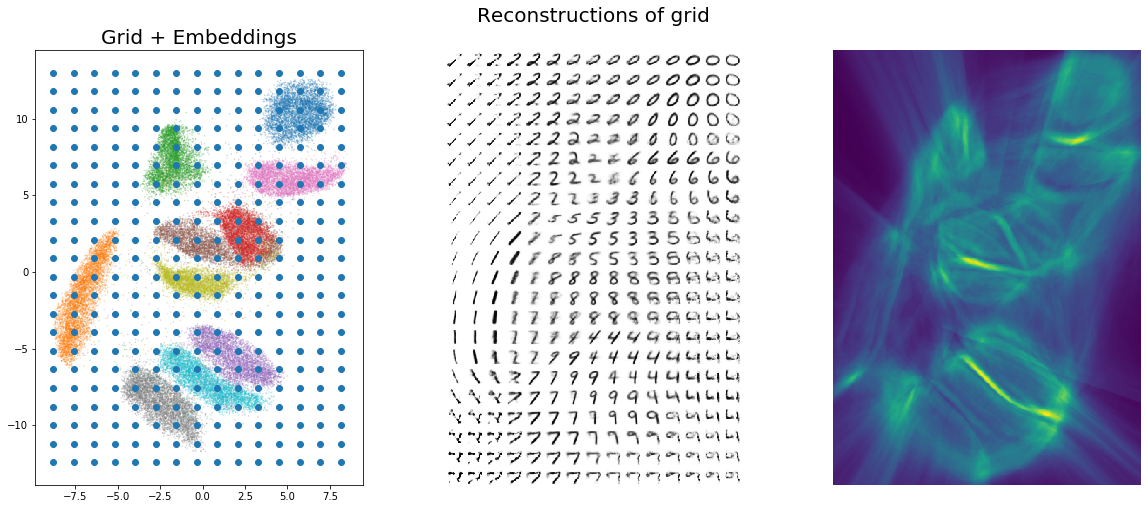

In [121]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    embedding_x,
    embedding_y,
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.set_title("Grid + Embeddings", fontsize=20)
#plt.colorbar(sc, ax=ax)
#ax.axis('equal')
ax.scatter(x_tiled, y_tiled)
ax = axs[1]
ax.set_title("Reconstructions of grid", fontsize=20)

ax.matshow(tiled_reconstructions.squeeze(), cmap = plt.cm.Greys)
ax.axis('off')


ax = axs[2]
ax.matshow(grad_magnitude.T, cmap = plt.cm.Greys)
ax.axis('off')

plt.show()

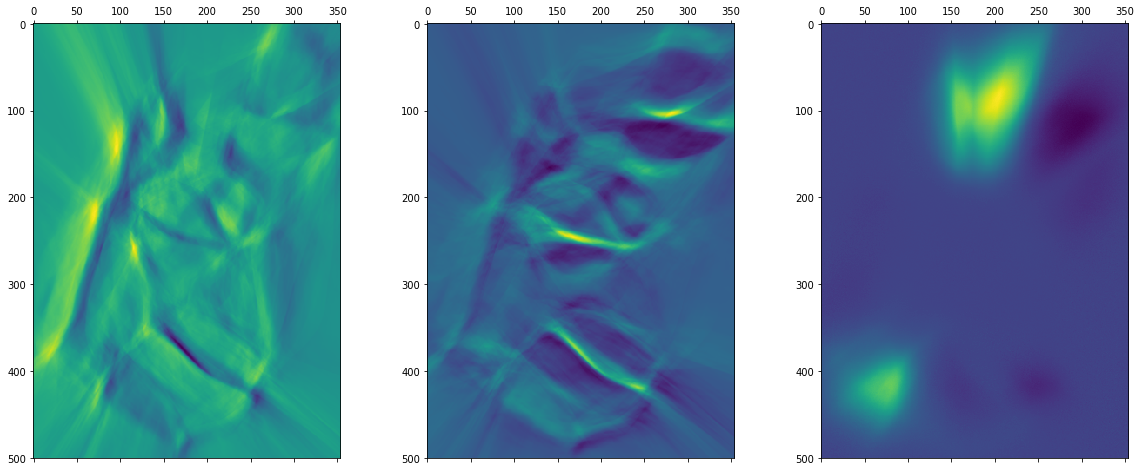

In [132]:
fig, axs = plt.subplots(ncols=3, figsize=(20,8))
axs[0].matshow(rec_grad[0].sum(axis=2).T, cmap=plt.cm.viridis)
axs[1].matshow(rec_grad[1].sum(axis=2).T, cmap=plt.cm.viridis)
axs[2].matshow(rec_grad[2].sum(axis=2).T, cmap=plt.cm.viridis)

### Spatial arrangement of data

In [134]:
import copy

In [145]:
def plot_greyscale_projections(
    embedding, pct=90, padding=0.5, pix_max=2000, canvas_max_val=1
):

    embedding_x = embedding[:, 0]
    embedding_y = embedding[:, 1]

    # get range of plot
    xmin = np.percentile(embedding_x, (100 - pct))
    xmax = np.percentile(embedding_x, (pct))
    ymin = np.percentile(embedding_y, (100 - pct))
    ymax = np.percentile(embedding_y, (pct))
    xpad = (xmax - xmin) * padding
    ypad = (ymax - ymin) * padding
    xmin = xmin - xpad
    xmax = xmax + xpad
    ymin = ymin - ypad
    ymax = ymax + xpad

    ### make canvas
    pix_spacing = np.max([xmax - xmin, ymax - ymin]) / pix_max
    pix_spacing

    pix_x = int((xmax - xmin) / pix_spacing)
    pix_y = int((ymax - ymin) / pix_spacing)
    canvas = np.zeros((pix_x, pix_y))

    for embedding_z, image in tqdm(zip(embedding, dat_subset), total=len(embedding)):
        image = image.reshape(dims).squeeze()
        shape_x, shape_y = np.shape(image)
        x_start = int((embedding_z[0] - xmin) / (xmax - xmin) * pix_x) - int(
            shape_x / 2
        )
        x_end = x_start + shape_x
        y_start = int((embedding_z[1] - ymin) / (ymax - ymin) * pix_y) - int(
            shape_y / 2
        )
        y_end = y_start + shape_y
        # print(embedding_z)
        # print(embedding_z, x_start, x_end, y_start, y_end)
        if (x_start < 0) or (x_end > pix_x) or (y_start < 0) or (y_end > pix_y):
            continue

        canvas[x_start:x_end, y_start:y_end] += image
    canvas[canvas > canvas_max_val] = canvas_max_val

    return canvas

In [ ]:
dat = copy.deepcopy(X_train).squeeze()
y = copy.deepcopy(Y_train)
embedding = copy.deepcopy(z)

In [156]:
canvas = plot_greyscale_projections(embedding[y == 0], pix_max=1000, canvas_max_val=2)

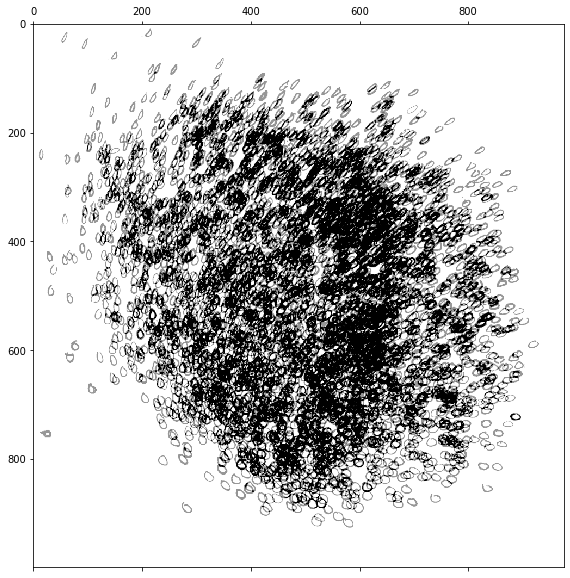

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap='Greys')#, extent = [xmin, xmax, ymin, ymax])
#ax.axis('equal')
plt.show()